#  データ分析と結果の保存
##  データ投入

In [ ]:
import pandas as pd
import numpy as np
titanic_df = pd.read_csv('./input_data/Titanic_train.csv')

#  列名をDBの定義に合わせて先に統一する
titanic_df.rename(columns={
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'p_class',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'sib_sp',
    'Parch': 'parch',
    'Ticket': 'ticket',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked'
}, inplace=True)

In [2]:
from sqlalchemy import create_engine

import os
pgconfig = {
    'host' : os.environ['DB_HOST']
    , 'port': os.environ['DB_PORT']
    , 'database': os.environ['DB_NAME']
    , 'user': os.environ['DB_USER']
    , 'password': os.environ['DB_PASSWORD']
}

engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'.format(**pgconfig))

In [3]:
import sqlalchemy

In [4]:
# 前処理したデータをtitanic_inputテーブルに保存
# カラム名をDBの定義に合わせ
titanic_df.to_sql('titanic_input', engine, if_exists='replace', index=False)
print("titanic_inputテーブルへのデータ保存が完了しました。")

titanic_inputテーブルへのデータ保存が完了しました。


###  データの参照

In [5]:
print(pgconfig)

{'host': 'db', 'port': '5432', 'database': 'analysis', 'user': 'testuser', 'password': 'password'}


In [6]:
from sql.connection import Connection
Connection.connections.clear()

In [7]:

%reload_ext sql
dsl = 'postgresql://{user}:{password}@{host}:{port}/{database}'.format(**pgconfig)
dsl = 'postgresql://testuser:password@db:5432/analysis'
%sql $dsl

In [8]:
%config SqlMagic.autopandas =True
titanic_df = %sql select * from titanic_input
titanic_df.head()

 * postgresql://testuser:***@db:5432/analysis
891 rows affected.


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


##  分析の実行

In [9]:
# Ageの欠損値を中央値で補完
titanic_df['age'].fillna(titanic_df['age'].median(), inplace=True)
#Embarkedの欠損値を最頻値で補完
titanic_df['embarked'].fillna(titanic_df['embarked'].mode()[0], inplace=True)
#Cabinは欠損が多すぎるため、今回は使用しない
titanic_df.drop('cabin', axis=1, inplace=True)
# 分析に使用する列を再定義a
df = titanic_df[['passenger_id', 'survived', 'p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked']].copy()
# カテゴリ変数を数値に変換
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
# データ型の変更
df = df.astype({'p_class': 'int', 'sex': 'int', 'age': 'float', 'sib_sp': 'int', 'parch': 'int', 'fare': 'float', 'embarked': 'int'})
print("前処理後のデータ:")
df.head()

前処理後のデータ:


,passenger_id,survived,p_class,sex,age,sib_sp,parch,fare,embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#特徴量(X)と目的変数(y)を定義
features = ['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked']
X = df[features]
y = df['survived']
# 学習データとテストデータに分割\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ロジスティック回帰モデルの学習\n",
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# 全データに対して予測を実行\n",
predictions = model.predict(X)
df['survived_prediction'] = predictions
print(f"モデルの正解率(Accuracy): {accuracy_score(y, predictions):.4f}")

モデルの正解率(Accuracy): 0.8025


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


##  分析結果の保存

In [11]:
# 予測結果を保存するためのDataFrameを作成
df_prediction = df[['passenger_id', 'survived_prediction']]
# titanic_survival_predictionテーブルに保存
df_prediction.to_sql('titanic_survival_prediction', engine, if_exists='replace', index=False)
print("titanic_survival_predictionテーブルへのデータ保存が完了しました。")

titanic_survival_predictionテーブルへのデータ保存が完了しました。


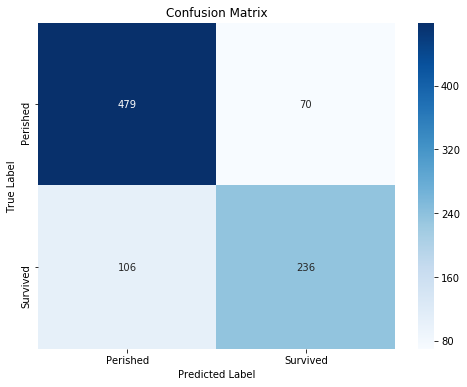

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# 混同行列を作成
cm = confusion_matrix(y, predictions)
# ヒートマップで可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Perished', 'Survived'], yticklabels=['Perished', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()